In [1]:
%reset -f
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping, ReduceLROnPlateau, CSVLogger
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.densenet import DenseNet121, DenseNet201
from tensorflow.keras.applications import NASNetLarge, Xception
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import pandas as pd
import cv2, os, os, git, glob, random
import numpy as np
from insectrec.utils import get_dataset, train_generator, valid_generator, augment_trainset
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
seed = 42
np.random.seed(seed)

created_data_path = f'/home/kalfasyan/data/images/sticky_plates/created_data'
path_crops_export = f'{created_data_path}/crops_export/'
path_images_augmented = f'{created_data_path}/images_augmented/'

if not os.path.isdir(path_images_augmented):
    os.mkdir(path)
    
clean = False
if clean:
    print("Deleting old augmented")
    os.system(f'rm -rf {path_images_augmented}*')

nb_classes = 9
epochs = 100
batch_size = 32
monitor='val_accuracy'
es_patience=7
rlr_patience=3
img_dim = 150
modelname = f'DenseNet121_{nb_classes}classes_{img_dim}'

nr of test plates: 21
nr of all plates: 253


/home/kalfasyan/anaconda3/envs/objdetect/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)
/home/kalfasyan/anaconda3/envs/objdetect/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)
/home/kalfasyan/anaconda3/envs/objdetect/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)
/home/kalfasyan/anaconda3/envs/objdetect/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


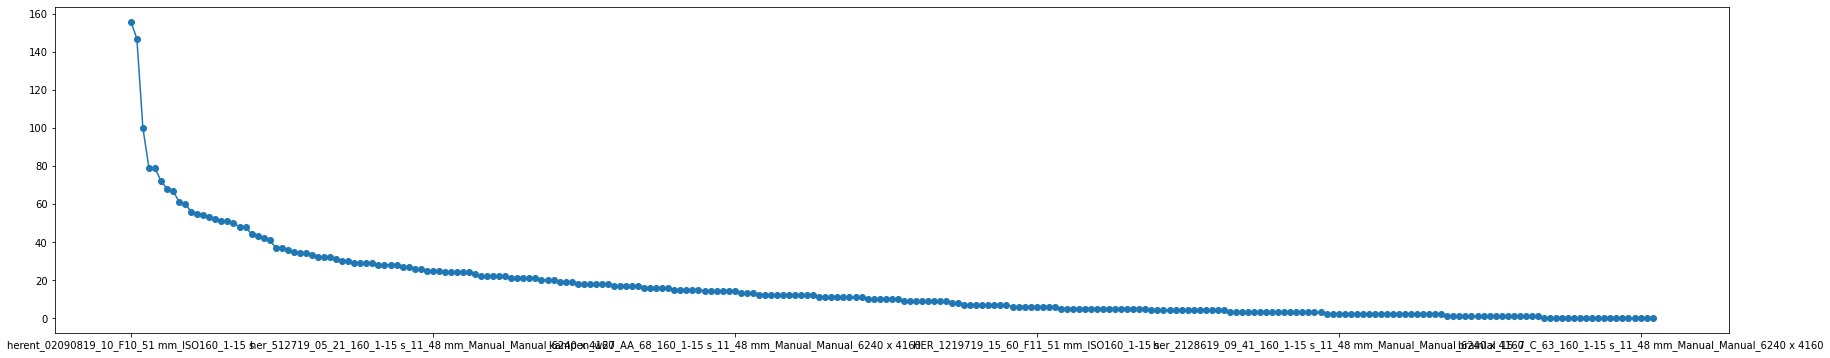

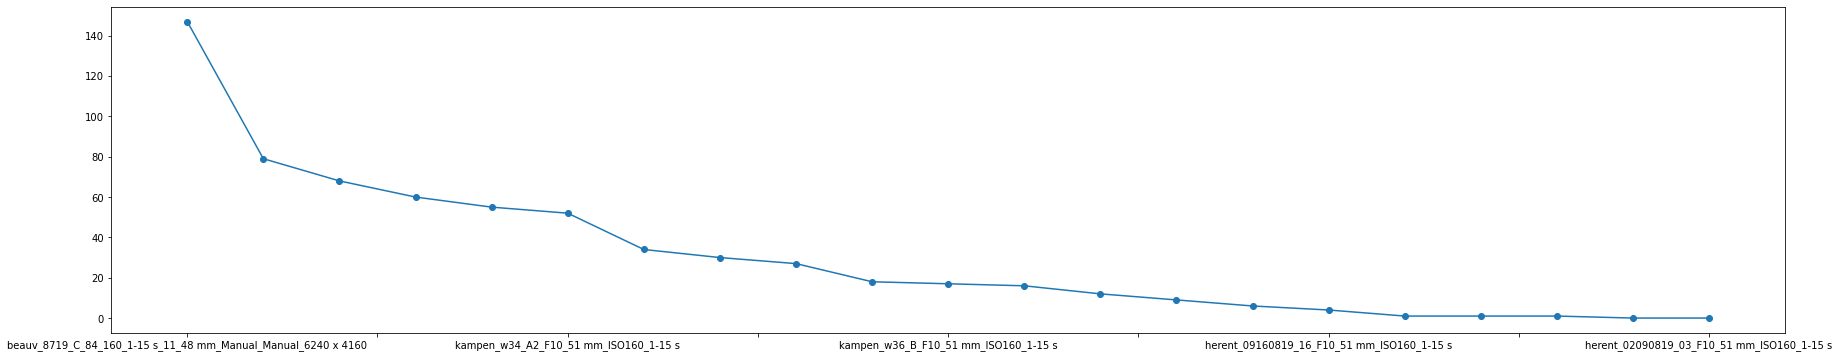

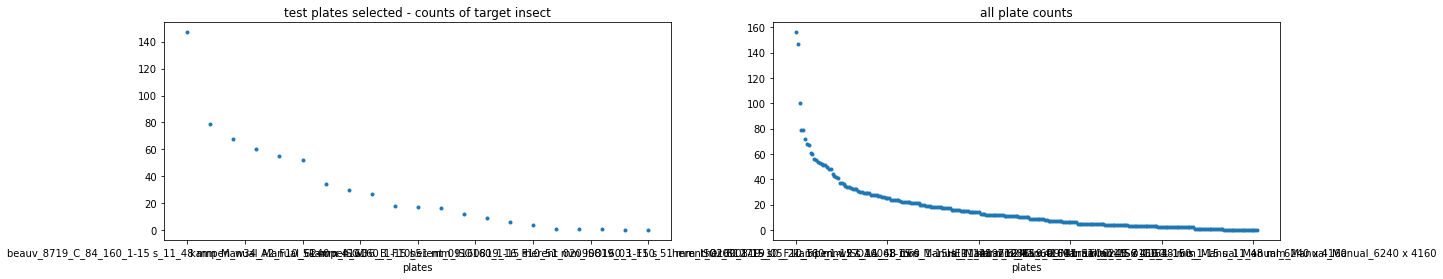

In [2]:
# Creating le for encoding labels
le = LabelEncoder()

# Creating dataframe with all the original data (x: filenames, textlabels, y: nummerical labels)
df_orig = pd.DataFrame()
df_orig['x'] = pd.Series(glob.glob(f"{path_crops_export}/*/*.jpg"))
df_orig['pname'] = df_orig['x'].apply(lambda p: p.split('/')[-1][:-4])
df_orig['pname'] = df_orig['pname'].apply(lambda x: '_'.join(x.split('_')[:-1]))
df_orig['y_text'] = df_orig['x'].apply(lambda x: x.split('/')[-2])
df_orig['y'] = le.fit_transform(df_orig.y_text)

target_insect_dict = {}
for i, sub in df_orig.groupby(['pname']):
    try:
        target_insect_dict[i] = sub['y_text'][sub['y_text']=='wmv'].value_counts()[0]
    except:
        target_insect_dict[i] = 0
ser = pd.Series(target_insect_dict, index=target_insect_dict.keys()).sort_values(ascending=False)
# Sampling some test plates. 2 from first 5, 2 from next five....
test_plates = []
test_plates.extend(ser.iloc[:5].sample(2, random_state=42).index.values.tolist())
test_plates.extend(ser.iloc[5:10].sample(2, random_state=42).index.values.tolist())
test_plates.extend(ser.iloc[10:15].sample(2, random_state=42).index.values.tolist())
test_plates.extend(ser.iloc[20:].sample(15, random_state=42).index.values.tolist())
test_plates = ser.loc[test_plates].sort_values(ascending=False).index.tolist()

ser.plot(marker='o', figsize=(30,6))
plt.figure()
ser.loc[test_plates].sort_values(ascending=False).plot(marker='o', figsize=(30,6))

plt.figure(figsize=(20,4))
plt.subplot(121)
ser.loc[test_plates].plot(style='.'); plt.xlabel('plates');plt.title('test plates selected - counts of target insect')
print(f"nr of test plates: {ser.loc[test_plates].shape[0]}")
plt.subplot(122)
ser.plot(style='.'); plt.xlabel('plates'); plt.title('all plate counts')
print(f"nr of all plates: {ser.shape[0]}")

X_test = df_orig.x[df_orig.pname.isin(test_plates)]
y_test = df_orig.y[df_orig.pname.isin(test_plates)]

X_test, y_test = shuffle(X_test, y_test, random_state=seed)

In [3]:
print("Test set class balance")
print(df_orig[df_orig.pname.isin(test_plates) ].y_text.value_counts())

X_train = df_orig.x[~df_orig.pname.isin(test_plates)]
y_train = df_orig.y[~df_orig.pname.isin(test_plates)]

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=seed, shuffle=True)

Test set class balance
wmv      637
v        368
m        252
c        193
v(cy)    191
t        172
sw       159
bv       128
bl       106
Name: y_text, dtype: int64


In [4]:
# Splitting into train/val/test # Randomly
# X_train, X_test, y_train, y_test = train_test_split(df_orig.x, df_orig.y, test_size=0.2, random_state=seed, shuffle=True)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=seed, shuffle=True)

## DenseNet121 trained from scratch

In [5]:
from tensorflow.keras.applications import NASNetLarge

base_model = DenseNet121(include_top=False, weights=None, 
                         input_shape=(img_dim,img_dim,3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
# x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(nb_classes, activation=None)(x)
predictions = Activation('softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)
# model.summary()

In [6]:
import math
top_weights_path = f"{created_data_path}/weights/{modelname}.h5"
model.load_weights(top_weights_path)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [7]:
pred = model.predict(valid_generator(X_test.tolist(), y_test.tolist(), batch_size=batch_size, nb_classes=nb_classes, img_dim=img_dim), 
                         steps= len(X_test) / batch_size, 
                         verbose=1)

69/68 [==============================] - 6s 94ms/step


In [8]:
y_pred = np.argmax(pred, axis=1)

In [9]:
def get_labelencoder_mapping(le):
    '''
    Return a dict mapping labels to their integer values
    from an SKlearn LabelEncoder
    le = a fitted SKlearn LabelEncoder
    '''
    res = {}
    for cl in le.classes_:
        res.update({cl:le.transform([cl])[0]})

    return res

get_labelencoder_mapping(le)
name_map = dict(zip(le.transform(le.classes_), le.classes_))
print(name_map)

{0: 'bl', 1: 'bv', 2: 'c', 3: 'm', 4: 'sw', 5: 't', 6: 'v', 7: 'v(cy)', 8: 'wmv'}


## Confusion matrix

0.6901324578658736


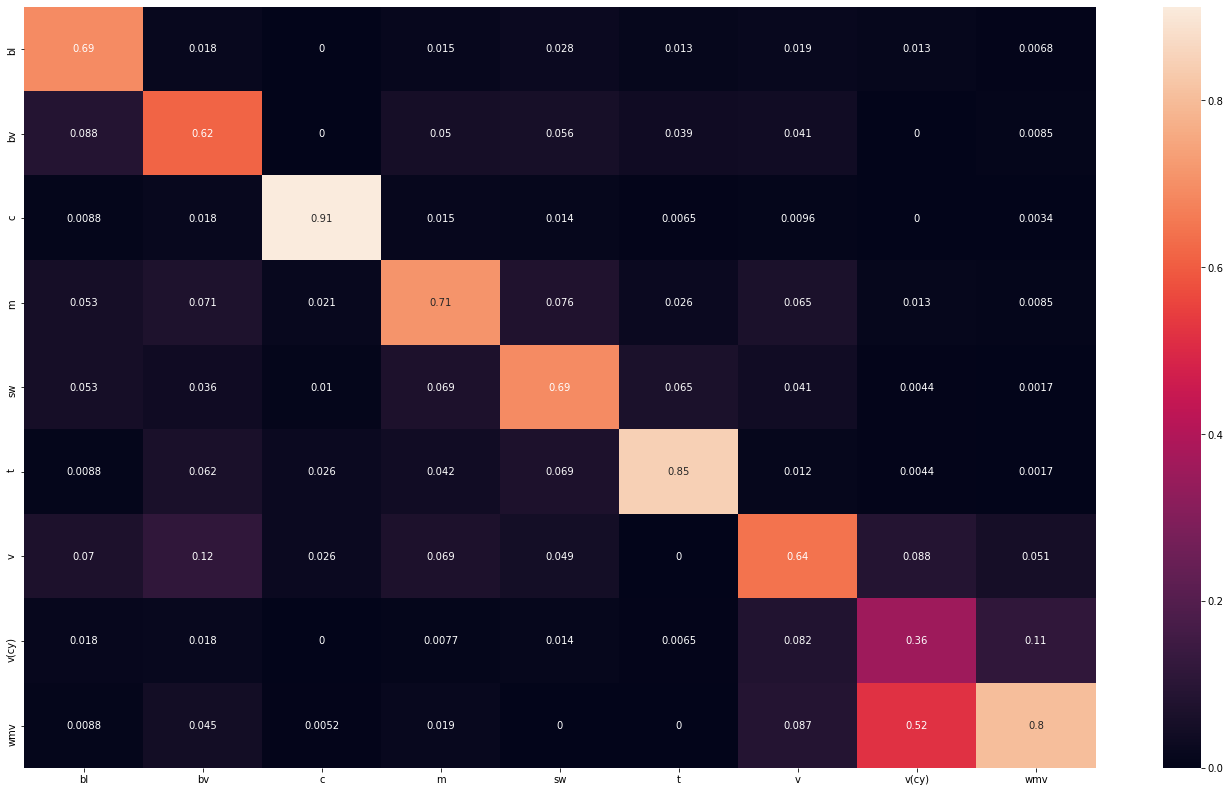

In [10]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix
import seaborn as sns
print(balanced_accuracy_score(y_test, y_pred))


plt.figure(figsize=(24,14))
cm = confusion_matrix(le.fit_transform(y_test), y_pred)
cm = cm / cm.astype(np.float).sum(axis=0)
sns.heatmap(cm, annot=True, xticklabels=list(name_map.values()), yticklabels=list(name_map.values()))
sns.set(font_scale=1.4)

<AxesSubplot:>

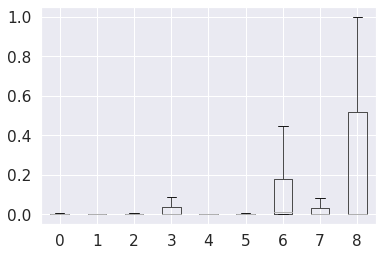

In [11]:
pd.DataFrame(pred).sort_values(by=8, ascending=False).boxplot(showfliers=False)

## Classification report

In [10]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.85      0.86       311
           1       0.69      0.50      0.58       167
           2       0.91      0.86      0.88       233
           3       0.85      0.81      0.83       613
           4       0.60      0.46      0.52       175
           5       0.83      0.77      0.80       292
           6       0.59      0.76      0.66       563
           7       0.63      0.45      0.53       430
           8       0.63      0.78      0.70       489

    accuracy                           0.72      3273
   macro avg       0.73      0.69      0.71      3273
weighted avg       0.73      0.72      0.72      3273



## Actual number of flies vs Predicted by model

In [11]:
trgt = 8 # wmv code
acts, pred, pnames = [],[],[]
df_test['y_pred'] = y_pred
for i, sub in df_test.groupby('insect_plate_names'):
    acts.append(sub.actual_number.iloc[0])
    pred.append(sub[sub.y_pred == trgt].shape[0])
    pnames.append(sub.insect_plate_names.iloc[0])
#     print(f"\nplate: {sub.insect_plate_names.iloc[0]} \nactual: {sub.actual_number.iloc[0]}, predicted: {sub[sub.y_pred == trgt].shape[0]}")
#     break

NameError: name 'df_test' is not defined

covariance matrix: 
[[554.24456522  53.42934783]
 [ 53.42934783 223.65036232]]

Pearsons correlation: 0.152



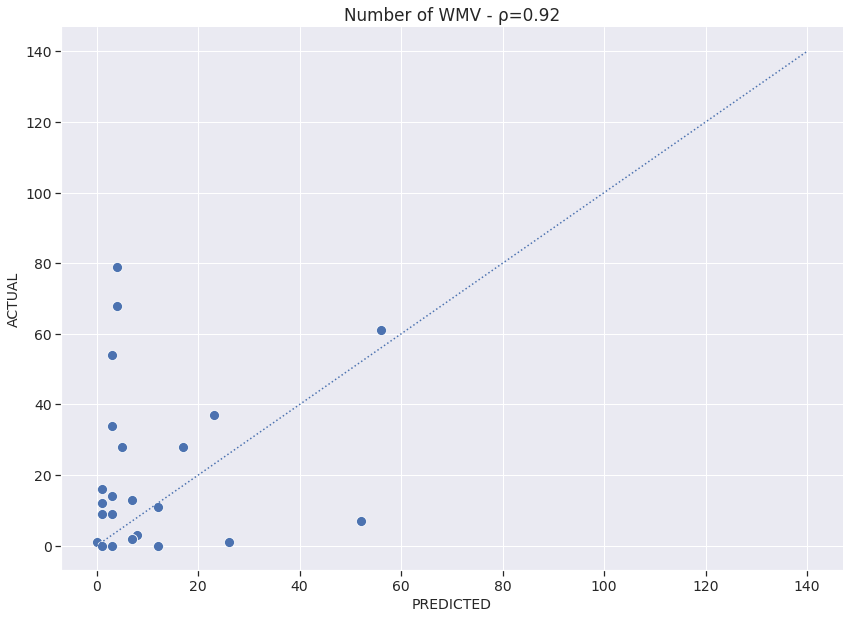

In [24]:
# sns.scatterplot(pred, acts)
df_plot = pd.DataFrame({"acts": acts, "pred": pred})

plt.figure(figsize=(14,10))
ax = sns.scatterplot(x="pred", y="acts", data=df_plot, ci=None, s=100);
ident = [0.0, 140.0]
plt.plot(ident,ident, ":")
plt.title("Number of WMV - ρ=0.92")
plt.xlabel("PREDICTED", fontsize=14)
plt.ylabel("ACTUAL", fontsize=14)
# plt.legend(['ρ=0.92'])

from scipy.stats import pearsonr
from numpy import cov

covariance = cov(df_plot.acts, df_plot.pred)
print(f"covariance matrix: \n{covariance}\n")

corr, _ = pearsonr(df_plot.acts, df_plot.pred)
print('Pearsons correlation: %.3f' % corr)
print()

ax.tick_params(axis='both', which='major', labelsize=14)
# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

In [25]:
df_plot['platenames'] = pnames
df_plot[['platenames','acts','pred']].set_index('platenames').sort_values(by='acts', ascending=False)

,acts,pred
platenames,,
kampen_w26_C_79_160_1-15 s_11_48 mm_Manual_Manual_6240 x 4160,79,4
herent_09160819_10_F10_51 mm_ISO160_1-15 s,68,4
kampen_w32_AA_17_F10_51 mm_ISO160_1-15 s_3daysold,61,56
brainlal_w27_B_59_160_1-15 s_11_48 mm_Manual_Manual_6240 x 4160,54,3
herent_09160819_13_F10_51 mm_ISO160_1-15 s,37,23
beauv_w27_C_57_160_1-15 s_11_48 mm_Manual_Manual_6240 x 4160,34,3
her_2856719_03_03_160_1-15 s_11_48 mm_Manual_Manual_6240 x 4160,28,17
herent_09160819_14_F10_51 mm_ISO160_1-15 s,28,5
beauvech_w37_B_F10_51 mm_ISO160_1-15 s,16,1


In [26]:
data1

NameError: name 'data1' is not defined